In [1]:
import tinyarray as ta
import numpy as np
import matplotlib.pyplot as plt
import importlib
import json
import kwant

from codes.gate_design import gate_coords
from codes.constants import scale
import codes.trijunction as trijunction
import codes.optimization as optimization
import codes.parameters as parameters
from codes.tools import hamiltonian
from codes.utils import eigsh, svd_transformation, dict_update, dep_acc_index
from codes.utils import order_wavefunctions, ratio_Gaussian_curvature

VoronoiMesh version 0.1
DiscretePoisson version 0.3
Shape version: 0.1
SystEquations version: 0.3
Solver version 0.1


In [2]:
from scipy.optimize import minimize

In [3]:
with open('/home/tinkerer/trijunction-design/codes/config.json', 'r') as f:
    config = json.load(f)

change_config = [
    {"device": {"thickness": {"dielectric": 1.0}}},
    {"gate": {"channel_width": 13.0, 'angle': np.pi/6, 'gap': 2}},
]

for local_config in change_config:
    config = dict_update(config, local_config)

### Optimal voltages

In [18]:
system.optimal_voltages

{'left-right': {'left_1': -0.002596775480124644,
  'left_2': -0.002596775480124644,
  'right_1': -0.0025958232533803264,
  'right_2': -0.0025958232533803264,
  'top_1': -0.002929134715507254,
  'top_2': -0.002929134715507254,
  'global_accumul': -0.0017463488239404998,
  'dirichlet_0': 0.0,
  'dirichlet_1': 0.0,
  'dirichlet_2': 0.0,
  'dirichlet_3': 0.0,
  'dirichlet_4': 0.0,
  'dirichlet_5': 0.0}}

In [5]:
pair = 'left-right'
voltages = parameters.pair_voltages()

In [6]:
zero_potential = dict(
    zip(
        ta.array(system.site_coords[:, [0, 1]] - system.offset),
        np.zeros(len(system.site_coords)),
    )
)

In [7]:
kwant_args = list(system.optimiser_arguments().values())
kwant_args[-1] = kwant_args[-1][order_wavefunctions(pair)]

In [8]:
x = [-1.0e-3, -1.0e-3, -5.0e-3, 3e-3]
voltages = parameters.voltage_dict(x)

In [9]:
params = parameters.junction_parameters()
params.update(voltages)
params.update(potential=zero_potential)

In [10]:
opt_args = tuple([pair, params, kwant_args, 0.0])

In [11]:
kwant_sites = np.array([site.pos for site in system.trijunction.sites])
soft_threshold_indices = dep_acc_index(
    zip(system.gate_names, system.gates_vertex),
    system.nw_centers,
               kwant_sites,
               config['gate']['angle'],
               scale,
               10
               )

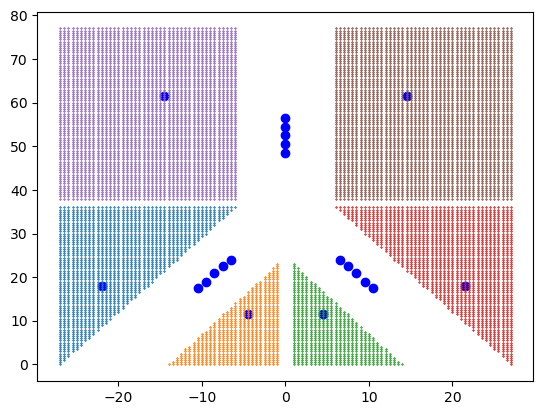

In [12]:
site_coords = system.grid_points[system.site_indices]
for index in np.hstack(list(soft_threshold_indices.values())):
    point = kwant_sites[index]/scale
    plt.scatter(point[0], point[1], c='b')

for key, value in system.poisson_system.regions.voltage.tag_points.items():
    if not key.startswith(('global', 'dirichlet')):
        coords = system.grid_points[value]
        plt.scatter(coords[:, 0], coords[:, 1], s = 0.1)

In [13]:
kwant_sites = np.array([site.pos for site in system.trijunction.sites])/scale
params.update({'dep_acc_index': soft_threshold_indices})

In [14]:
step_size = 1e-4
opt_args = tuple((pair, params, kwant_args, 0.0, step_size))
# optimization.loss(x, *opt_args)

In [15]:
import codes.optimization
import importlib
importlib.reload(codes.optimization)

<module 'codes.optimization' from '/home/tinkerer/trijunction-design/analysis/codes/optimization.py'>

In [ ]:
sol1 = minimize(
            codes.optimization.loss,
            x,
            args=opt_args,
            method="trust-constr",
            # jac=codes.optimization.jacobian,
            options={
                "verbose":2,
                "initial_tr_radius":1e-3,
            },
        )

In [ ]:
deltaV = np.linspace(-2, 5, 100) * 1e-3
scattering_region_density = kwant.operator.Density(system.trijunction, where=bounds)
kwant_sites = np.array([site.pos for site in system.trijunction.sites])

In [ ]:
from tqdm import tqdm

In [ ]:
# wave_functions = []
# ratios = []
# desired_couplings = []
# undesired_couplings = []
shape, loss = [], []
for v in tqdm(deltaV):
    a, b = codes.optimization.loss([-0.00343678 + v, 
                                    -0.00343654 + v, 
                                    -0.01941018,  
                                    0.00980045], 
                                   *opt_args
                                  )
    shape.append(a)
    loss.append(b)
#     params.update(parameters.voltage_dict([-0.00343678 + v, 
#                                            -0.00343654 + v, 
#                                            -0.01941018,  
#                                            0.00980045]))
#     linear_ham, numerical_hamiltonian = hamiltonian(system.trijunction, 
#                                     optimiser_args['linear_terms'], 
#                                     optimiser_args['kwant_params_fn'], 
#                                     **params)
#     energies, wave_function = eigsh(
#                 numerical_hamiltonian.tocsc(),
#                 6,
#                 sigma=0,
#                 return_eigenvectors=True,
#     )
#     transformed_hamiltonian = svd_transformation(
#     energies, wave_function, system.mlwf[order_wavefunctions('left-right')]
#     )

#     desired_couplings.append(np.abs(transformed_hamiltonian[0, 1]))
#     undesired_couplings.append(np.linalg.norm(transformed_hamiltonian[2:]))
    
#     step = system.geometry['grid_spacing']*scale

#     xmin, xmax, ymin, ymax = np.array(list(system.boundaries.values()))*scale
#     bounds = lambda site: (site.pos[0] > xmin 
#                         and site.pos[0] < xmax
#                         and site.pos[1] > ymin
#                         and site.pos[1] < ymax)
    
    
#     wavefunction_density = scattering_region_density(wave_function[:, 0])

#     scattering_sites = kwant_sites[[bounds(site) for site in system.trijunction.sites]]
#     x, y = scattering_sites[:, 0], scattering_sites[:, 1]
#     nx, ny = len(np.unique(x)), len(np.unique(y))

#     interpolated_wavefunction = wavefunction_density.reshape((nx, -1))
    
#     ratios.append(ratio_Gaussian_curvature(interpolated_wavefunction, step))


In [ ]:
fig, ax = plt.subplots(4, 1, figsize=(4, 6), sharex=True)
r = 15
ax[0].plot(deltaV[r:], ratios[r:], '-', c='r')
# ax[0].vlines(0.0, -5, -0.5, 'r')

ax[0].set_ylabel(r'$\frac{K_{min}}{K_{max}}$', fontsize=11)

ax[1].plot(deltaV[r:], np.array(desired_couplings)[r:]/40e-6, '-', c='r')
ax[1].set_ylabel(r'Couplings $\Delta_t$', fontsize=11)


ax[2].plot(deltaV[r:], np.array(shape)[r:]/40e-6, '-', c='r')
ax[2].set_ylabel('Potential error(V)', fontsize=11)

ax[3].plot(deltaV[r:],( np.array(loss) - np.array(shape))[r:]/40e-6, '-', c='r')
ax[3].set_ylabel('Default loss', fontsize=11)

ax[3].set_xlabel('Detuning (V)', fontsize=11)

In [ ]:
params.update(parameters.voltage_dict(sol1.x))
linear_ham, numerical_hamiltonian = hamiltonian(system.trijunction, 
                                optimiser_args['linear_terms'], 
                                optimiser_args['kwant_params_fn'], 
                                **params)

In [ ]:
energies, wave_function = eigsh(
                numerical_hamiltonian.tocsc(),
                6,
                sigma=0,
                return_eigenvectors=True,
    )

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5), sharey= True)

density = kwant.operator.Density(system.trijunction, np.eye(4))
for i, vec in enumerate(wave_function.T[[0]]):
    kwant.plotter.density(system.trijunction, density(vec), ax=ax);


In [ ]:
transformed_hamiltonian = svd_transformation(
    energies, wave_function, system.mlwf[order_wavefunctions('left-right')]
)

desired = np.abs(transformed_hamiltonian[0, 1])
undesired = np.linalg.norm(transformed_hamiltonian[2:])

### Initial voltage guess

In [29]:
kwant_sites = [site.pos for site in system.trijunction.sites]

In [30]:
gates_dict = zip(system.gate_names, system.gates_vertex)
indices = dep_acc_index(
    gates_dict,
    system.nw_centers,
    kwant_sites,
    config['gate']['angle'],
    shift=3,
    spacing = 3,
    npts=5
)

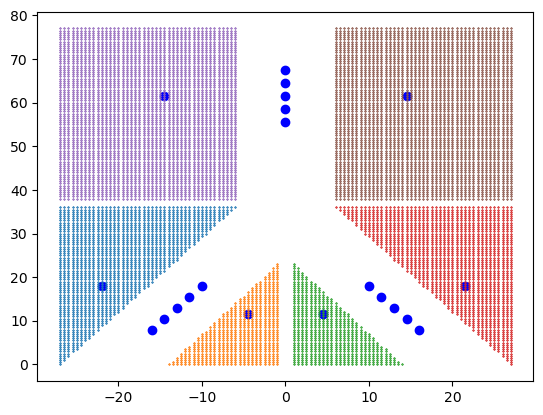

In [31]:
site_coords = system.grid_points[system.site_indices]
for gate, index in indices.items():
    point = kwant_sites[index]/scale
    plt.scatter(point[0], point[1], c='b')

for key, value in system.poisson_system.regions.voltage.tag_points.items():
    if not key.startswith(('global', 'dirichlet')):
        coords = system.grid_points[value]
        plt.scatter(coords[:, 0], coords[:, 1], s = 0.1)

In [200]:
pair = 'left-right'
params = parameters.junction_parameters()
params.update(potential=system.flat_potential())
# base_ham = system.trijunction.hamiltonian_submatrix(
#     sparse=True, params=system.f_params(**params)
# )
args = (pair.split('-'),
        (system.base_ham, system.linear_terms, system.densityoperator),
        indices, 
        )

In [201]:
initial_condition = (-1.5e-3, -1.5e-3, -1.5e-3, 3e-3)

In [202]:
from codes.optimization import soft_threshold_loss

In [203]:
import codes.optimization
import importlib
importlib.reload(codes.optimization)

<module 'codes.optimization' from '/home/tinkerer/trijunction-design/analysis/codes/optimization.py'>

In [205]:
sol1.x

array([-0.00369684, -0.00391238, -0.0085203 ,  0.00924925])

In [206]:
optimal_voltages = parameters.voltage_dict(sol1.x)

In [207]:
params = parameters.junction_parameters()
params.update(potential=system.flat_potential())
params.update(optimal_voltages)

In [208]:
from codes.constants import bands


In [209]:
linear_ham, full_ham = hamiltonian(system.base_ham, 
                                   system.linear_terms, 
                                   system.f_params, 
                                   **params)

potential = linear_ham.diagonal()[::4]
step_potential = np.array(np.abs(potential) > bands[0], dtype=int)

In [210]:
evals, evecs = eigsh(full_ham, k=6, sigma=0, return_eigenvectors=True)

In [211]:
transformed_hamiltonian = svd_transformation(
    evals, evecs, system.mlwf[order_wavefunctions(pair)]
)

desired = np.abs(transformed_hamiltonian[0, 1])
undesired = np.linalg.norm(transformed_hamiltonian[2:])

In [212]:
desired, undesired

(1.5273166881579242e-05, 3.6261539409447924e-08)

In [213]:
wfv = system.densityoperator(evecs[:, 0])

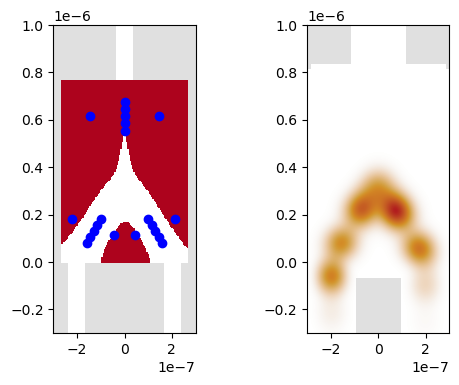

In [214]:
fig, ax = plt.subplots(ncols=2, figsize=(6, 4))
kwant.plotter.map(system.trijunction, lambda i: step_potential[i], ax=ax[0])
kwant.plotter.density(system.trijunction, wfv, ax=ax[1]);
for value in system.indices.values():
    ax[0].scatter(*kwant_sites[value], c='blue')
for axes in ax:
    axes.set_ylim(-3e-7, 10e-7)
    axes.set_xlim(-3e-7, 3e-7)